#**Drive mount**

In [ ]:
from google.colab import drive
import shutil
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import scipy.io
import pandas as pd
import os
import random
import cv2
import sklearn.metrics
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
from google.colab.patches import cv2_imshow
import skimage
import matplotlib.pyplot as plt
import itertools
import torch
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from scipy import signal
import matplotlib.pyplot as plt

In [ ]:
SUBJECTS_FOLDER = '/content/drive/MyDrive/Tirocinio/Datasets/Social memory cuing full dataset/derivatives/EEGPreprocessedDataTableStudy'
SINGLE_SUBJECT = os.path.join(SUBJECTS_FOLDER, "sub-34/ProcessedData/data_ica.mat")
SUBJECTS = [ name for name in os.listdir(SUBJECTS_FOLDER) if os.path.isdir(os.path.join(SUBJECTS_FOLDER, name)) ]
DATA = "ProcessedData/data_ica.mat"

In [ ]:
mat = scipy.io.loadmat(SINGLE_SUBJECT)
trial = mat['trial']
trialinfo = mat['trialinfo']

In [ ]:
trial = np.transpose(np.squeeze(trial))
trials = []
labels = []
NUM_CHANNELS = 29
NUM_TRIAL = 224
cueing_fase = range(1250,1750)
#encoding_fase = range()
for i, t in enumerate(trial):
  trials.append(t[ :NUM_CHANNELS, cueing_fase])
  labels.append(trialinfo[i, 5]-1)  #zero is stick, one is avatar --- the -1 to have labels with 0 or 1 values (in dataset are 1 and 2)

#trials = list(np.transpose(trials, [0, 2, 1]))
trials = list(signal.decimate(np.transpose(trials, [0, 2, 1]), 4, axis = 1)) #downsampling


print(np.shape(trials[0]))
#print(np.shape(labels))


(125, 29)


In [ ]:
print(f'Shape: ', np.shape(trials))
print()
print(type(trials))
print(type(trials[0][0][0]))
print(trials[0][0])
print(np.shape(trials[0][0]))

Shape:  (224, 125, 29)

<class 'list'>
<class 'numpy.float64'>
[-17.58227112 -31.03411281 -24.89601226  10.98182721 -28.56739956
 -11.88975447 -14.37107544  17.39609174   0.98526032 -10.10128604
 -17.31733843   3.36181593  18.35422871  -2.90500785  -9.79099322
 -10.68553525  16.551753     7.84930119   0.03228607  -8.05575676
   1.12886725   5.64164922  13.76585772  -1.48080577   6.21061471
  24.28707284   4.52834584   5.33621926  16.68523822]
(29,)


Sub Pari

<class 'numpy.ndarray'>


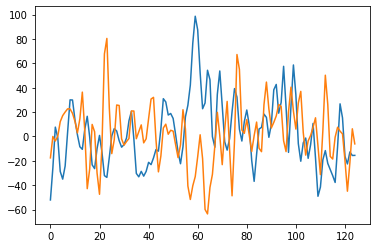

In [ ]:
if labels[0] == 0 and labels[112] == 1:
  print('Sub Dispari')

if labels[0] == 1 and labels[112] == 0:
  print('Sub Pari')

print()
print(type(trials[0]))

plt.plot(trials[1][:, 0])
plt.plot(trials[0][:, 0])

##**Normalizzazione**

In [ ]:
def _normalize_trial(trial):
  trial_avg = np.mean(trial)
  trial_std = np.std(trial)

  trial = (trial - trial_avg)/trial_std
  return trial

##**Dataset**

In [ ]:
class EEG_dataset(Dataset):

    def __init__(self, trials, labels):
        self.trials = trials
        self.labels = labels
        self._init_data()

    def _init_data(self):
        self.samples = []
        for i, trial in enumerate(self.trials):
            self.samples.append((trial, self.labels[i]))    
    
    def __len__(self):
      return len(self.samples)

    def __getitem__(self, idx):
      '''
      if self.labels[idx] == 3: #passive state
        label = torch.tensor(1, dtype=torch.long)
      else:
        label = torch.tensor(0, dtype=torch.long)
      '''
      return torch.tensor(_normalize_trial(self.trials[idx])), torch.tensor(self.labels[idx], dtype=torch.long)

In [ ]:
print(labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
from sklearn.model_selection import train_test_split

if labels[0] == 0 and labels[112] == 1:
  print('Sub Dispari')
  NONSOCIAL_RANGE = range(0,112)
  SOCIAL_RANGE = range(112,224)
  TRAIN_RANGE_S = range(0,79)
  TRAIN_RANGE_NONS = range(112,191)
  TEST_RANGE_S = range(79,101)
  TEST_RANGE_NONS = range(191,213)
  VAL_RANGE_S = range(101,112)
  VAL_RANGE_NONS = range(213,224)


  nonsoc_trials = []
  for nonsoc in NONSOCIAL_RANGE:
    nonsoc_trials.append(trials[nonsoc])
  seed = 42
  random.seed(seed)
  random.shuffle(nonsoc_trials)

  soc_trials = []
  for soc in SOCIAL_RANGE:
    soc_trials.append(trials[soc])
  seed = 42
  random.seed(seed)
  random.shuffle(soc_trials)

  trials = nonsoc_trials + soc_trials

  train_data = []
  train_labels = []
  for tns in TRAIN_RANGE_NONS:
    train_data.append(trials[tns])
    train_labels.append(labels[tns])
  for ts in TRAIN_RANGE_S:
    train_data.append(trials[ts])
    train_labels.append(labels[ts])

  test_data = []
  test_labels = []
  for tens in TEST_RANGE_NONS:
    test_data.append(trials[tens])
    test_labels.append(labels[tens])
  for tes in TEST_RANGE_S:
    test_data.append(trials[tes])
    test_labels.append(labels[tes])

  val_data = []
  val_labels = []
  for vns in VAL_RANGE_NONS:
    val_data.append(trials[vns])
    val_labels.append(labels[vns])
  for vs in VAL_RANGE_S:
    val_data.append(trials[vs])
    val_labels.append(labels[vs])

# ----- PARI ---------

if labels[0] == 1 and labels[112] == 0:
  print('Sub Pari')
  SOCIAL_RANGE = range(0,112)
  NONSOCIAL_RANGE = range(112,224)

  TRAIN_RANGE_S = range(0,79)
  TRAIN_RANGE_NONS = range(112,191)

  TEST_RANGE_S = range(79,101)
  TEST_RANGE_NONS = range(191,213)

  VAL_RANGE_S = range(101,112)
  VAL_RANGE_NONS = range(213,224)


  soc_trials = []
  for soc in SOCIAL_RANGE:
    soc_trials.append(trials[soc])
  seed = 42
  random.seed(seed)
  random.shuffle(soc_trials)

  nonsoc_trials = []
  for nonsoc in NONSOCIAL_RANGE:
    nonsoc_trials.append(trials[nonsoc])
  seed = 42
  random.seed(seed)
  random.shuffle(nonsoc_trials)

  trials = soc_trials + nonsoc_trials

  train_data = []
  train_labels = []

  for ts in TRAIN_RANGE_S:
    train_data.append(trials[ts])
    train_labels.append(labels[ts])
  for tns in TRAIN_RANGE_NONS:
    train_data.append(trials[tns])
    train_labels.append(labels[tns])

  test_data = []
  test_labels = []


  for tes in TEST_RANGE_S:
    test_data.append(trials[tes])
    test_labels.append(labels[tes])
  for tens in TEST_RANGE_NONS:
    test_data.append(trials[tens])
    test_labels.append(labels[tens])

  val_data = []
  val_labels = []


  for vs in VAL_RANGE_S:
    val_data.append(trials[vs])
    val_labels.append(labels[vs])
  for vns in VAL_RANGE_NONS:
    val_data.append(trials[vns])
    val_labels.append(labels[vns])

print(f'Train Data Shape: ', np.shape(train_data))
print(f'Test Data Shape: ', np.shape(test_data))
print(f'Val Data Shape: ', np.shape(val_data))

Sub Pari
Train Data Shape:  (158, 125, 29)
Test Data Shape:  (44, 125, 29)
Val Data Shape:  (22, 125, 29)


In [ ]:
print(f'Train Imbalance: ', train_labels.count(1)/len(train_labels))
print(f'Test Imbalance: ', test_labels.count(1)/len(test_labels))
print(f'Val Imbalance: ', val_labels.count(1)/len(val_labels))

Train Imbalance:  0.5
Test Imbalance:  0.5
Val Imbalance:  0.5


In [ ]:
train_dataset = EEG_dataset(train_data, train_labels)
val_dataset = EEG_dataset(val_data, val_labels)
test_dataset = EEG_dataset(test_data, test_labels)

#print(next(iter(train_dataset)))
#print(next(iter(val_dataset)))
#print(next(iter(test_dataset)))

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle=True)

In [ ]:
train_batch = next(iter(train_loader))
test_batch = next(iter(test_loader))
val_batch = next(iter(val_loader))
#print(train_batch)
print(type(train_batch))
print(f'Train batch type: ', type(train_batch[0]))
print(f'Test batch type: ', type(test_batch[0]))
print(f'Val batch type: ', type(val_batch[0]))
print(train_batch[0].shape)
train_batch[0] = torch.unsqueeze(train_batch[0], 0)
print(train_batch[0].shape)

<class 'list'>
Train batch type:  <class 'torch.Tensor'>
Test batch type:  <class 'torch.Tensor'>
Val batch type:  <class 'torch.Tensor'>
torch.Size([1, 125, 29])
torch.Size([1, 1, 125, 29])


In [ ]:
def set_device():
  if torch.cuda.is_available():
    dev = "cuda:0"
  else:
    dev = "cpu"
  return torch.device(dev)

# **Training**

In [ ]:
plot_train_acc = []
plot_val_acc = []
plot_train_loss = []

def train_nn(model, train_loader, val_loader, criterion, optimizer, n_epochs):
  device = set_device()
  best_acc = 0

  for epoch in range(n_epochs):
    print("Epoch number %d" %(epoch + 1))
    model.train()
    curr_loss = 0.0
    curr_true = 0.0
    total = 0
    for batch in train_loader:
      #print(type(batch))
      trial, labels = batch
      #print('Labels --->', labels)
      #print('Labels type --->', type(labels))
      #print('Prima cambio -->  ', images.dtype)
      #images = images.type('torch.DoubleTensor') 
      #print('Dopo cambio -->  ', images.dtype)
      #images = torch.tensor(images)
      #labels = torch.tensor(labels)
      #images = images.to(device)
      #labels = labels.to(device)
      total += labels.size(0) #perche anche se il batch è da 32 l'ultimo potrebbe essere più piccolo

      optimizer.zero_grad()

      #print('Shape trial prima di passarle al model', np.shape(trial))
      #outputs = model(trial)
      #print('Outputs prima --->', outputs)
      outputs = model(trial.unsqueeze(1).float())
      #print('Outputs prima--->', np.shape(outputs))
      #print(type(outputs))

      predicted = torch.round(outputs) #l'1 specifica il one dimension reduce


      #print('Outputs -->', np.shape(outputs))
      #print('Labels -->', np.shape(labels))
      loss = criterion(outputs, labels.float())

      loss.backward()
        
      optimizer.step()

      curr_loss += loss.item()
      curr_true += (labels==predicted).sum().item()

    
    epoch_loss = curr_loss/len(train_loader)
    epoch_accuracy = (curr_true/total)*100
    plot_train_acc.append(epoch_accuracy)
    plot_train_loss.append(epoch_loss)
    #scheduler.step()

    print("   -- Training Dataset. Got %d out of %d trials correctly (%.3f%%). Epoch Loss: %.3f" %(curr_true, total, epoch_accuracy, epoch_loss))

    val_acc = evaluate_model_val(model, val_loader)
    plot_val_acc.append(val_acc)


    if(val_acc >= best_acc):
      best_acc = val_acc
      save_checkpoint(model, epoch, optimizer, best_acc)
      save_best_model(model)

  print("\n  -- Done!")
  return model


In [ ]:
def save_checkpoint(model, epoch, optimizer, best_acc):
  state = {
      'epoch': epoch + 1,
      'model': model.state_dict(),
      'best accuracy': best_acc,
      'optimizer': optimizer.state_dict(),
      'comments': 'sub 33 NORM SGD'
  }
  torch.save(state, 'checkpoint.pth.tar')

In [ ]:
def save_best_model(model):
  torch.save(model, 'best_model.pth.tar')

In [ ]:
def evaluate_model_val(model, val_loader):
  model.eval()
  true_predicted_on_epoch = 0
  total = 0
  device = set_device()

  with torch.no_grad(): #reduce memory usage and speed up the evaluation (no backpropagation che non si fa sul test)
    for batch in val_loader:
      trial, labels = batch
      trial = trial.to(device)
      labels = labels.to(device)
      total += labels.size(0)

      outputs = model(trial.unsqueeze(1).float())

      predicted = torch.round(outputs)

      true_predicted_on_epoch += (predicted==labels).sum().item()

    epoch_accuracy = (true_predicted_on_epoch/total)*100

    print("   -- Val Dataset. Got %d out of %d trials correctly (%.3f%%)" %(true_predicted_on_epoch, total, epoch_accuracy))

  return epoch_accuracy

In [ ]:
num_classes = 2
NUM_CHANNELS = 29
device = set_device()
loss_fn = nn.BCELoss()

In [ ]:
from torch.nn.modules import dropout
class OurNet(nn.Module):

    def __init__(self):
        super(OurNet, self).__init__()
        torch.manual_seed(42)


        self.conv = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = (3, 3), stride = 4);
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = None, padding = 0);
        self.batch = nn.BatchNorm2d(num_features = 6);
        #self.act_f = nn.Hardshrink();
        self.act_f = nn.SELU();
        #self.act_f = nn.GELU();
        self.drop = nn.Dropout(p = 0.4)
        self.lin = nn.Linear(in_features = 120, out_features = 80); #1x120
        self.drop1 = nn.Dropout(p = 0.3);
        #self.lstm = nn.LSTM(input_size = 128, hidden_size = 250)
        self.lstm = nn.GRU(input_size = 80, hidden_size = 60)

        self.lastlayer = nn.Linear(in_features = 60, out_features = 1);

    def forward(self, x):
        hidden = self.conv(x);
        #print('Dopo conv --> ', hidden.size())
        #hidden = hidden.view(hidden.size()[0], -1)
        #hidden = torch.squeeze(hidden, dim = -1)
        #print('Dopo squeeze --> ', hidden.size())
        hidden = self.pool(hidden)
        #print('Dopo MaxPool1D --> ', hidden.size())
        hidden = self.batch(hidden)
        #print('Dopo Batch --> ', hidden.size())
        hidden = self.act_f(hidden)
        hidden = self.drop(hidden)
        hidden = torch.flatten(hidden, start_dim = 1 , end_dim = -1)
        #print('Dopo Flatten --> ', hidden.size())
        hidden = self.lin(hidden)
        #print('Dopo lin --> ', hidden.size())
        hidden = self.drop1(hidden)
        hidden,_ = self.lstm(hidden)
        #print('Dopo LSTM --> ', np.shape(hidden))
        out = self.lastlayer(hidden)
        #print('Dopo ultimo Lin --> ',out.size())
        out = torch.squeeze(out, dim = -1)
        #print('Dopo squeeze --> ',out.size())
        #print()
        out = torch.sigmoid(out)

        return out

In [ ]:
from torchvision import models
from torchsummary import summary

model = OurNet()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-5, dampening=0.1)
#optimizer = optim.Adam(model.parameters(), lr=1e-4)
#optimizer = optim.RMSprop(model.parameters(), lr=1e-4, weight_decay=1e-5)
train_nn(model, train_loader, val_loader, loss_fn, optimizer, 500)

Epoch number 1
   -- Training Dataset. Got 84 out of 158 trials correctly (53.165%). Epoch Loss: 0.694
   -- Val Dataset. Got 11 out of 22 trials correctly (50.000%)
Epoch number 2
   -- Training Dataset. Got 84 out of 158 trials correctly (53.165%). Epoch Loss: 0.687
   -- Val Dataset. Got 11 out of 22 trials correctly (50.000%)
Epoch number 3
   -- Training Dataset. Got 81 out of 158 trials correctly (51.266%). Epoch Loss: 0.692
   -- Val Dataset. Got 11 out of 22 trials correctly (50.000%)
Epoch number 4
   -- Training Dataset. Got 83 out of 158 trials correctly (52.532%). Epoch Loss: 0.684
   -- Val Dataset. Got 11 out of 22 trials correctly (50.000%)
Epoch number 5
   -- Training Dataset. Got 89 out of 158 trials correctly (56.329%). Epoch Loss: 0.677
   -- Val Dataset. Got 11 out of 22 trials correctly (50.000%)
Epoch number 6
   -- Training Dataset. Got 88 out of 158 trials correctly (55.696%). Epoch Loss: 0.681
   -- Val Dataset. Got 11 out of 22 trials correctly (50.000%)
Epoc

OurNet(
  (conv): Conv2d(1, 6, kernel_size=(3, 3), stride=(4, 4))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (batch): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_f): SELU()
  (drop): Dropout(p=0.4, inplace=False)
  (lin): Linear(in_features=120, out_features=80, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (lstm): GRU(80, 60)
  (lastlayer): Linear(in_features=60, out_features=1, bias=True)
)

In [ ]:
checkpoint = torch.load('checkpoint.pth.tar')

In [ ]:
print(checkpoint['epoch'])
print(checkpoint['best accuracy'])
print(checkpoint['comments'])

93
86.36363636363636
sub 33 NORM SGD


In [ ]:
best_model = torch.load('best_model.pth.tar')

In [ ]:
def evaluate_model_test(model, test_loader):
  model.eval()
  true_predicted_on_epoch = 0
  total = 0
  device = set_device()

  with torch.no_grad(): #reduce memory usage and speed up the evaluation (no backpropagation che non si fa sul test)
    for batch in test_loader:
      trial, labels = batch
      trial = trial.to(device)
      labels = labels.to(device)
      total += labels.size(0)

      outputs = model(trial.unsqueeze(1).float())

      predicted = torch.round(outputs)

      true_predicted_on_epoch += (predicted==labels).sum().item()

    epoch_accuracy = (true_predicted_on_epoch/total)*100

    print("   -- Test Dataset. Got %d out of %d trials correctly (%.3f%%)" %(true_predicted_on_epoch, total, epoch_accuracy))
    

  return epoch_accuracy

In [ ]:
test_acc = evaluate_model_test(best_model, test_loader)

   -- Test Dataset. Got 31 out of 44 trials correctly (70.455%)
